# Evaluate Results...

In [2]:
# === Config ===
import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','nature'])
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.labelsize'] = 12  # For x and y axis labels
plt.rcParams['xtick.labelsize'] = 12 # For x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12 # For y-axis tick labels
plt.rcParams['legend.fontsize'] = 12 # For legend text
plt.rcParams['font.size'] = 12       # For general text, title, etc.

feats=pd.read_csv("../res/Features_extraction_Mantra.csv")

## Config + utilidades + carga y tabla comparativa

In [3]:
BASE_DIR = "vg_cv"   # carpeta donde guardaste los prefijos (run_..._folds.json, _oof.csv, etc.)

# === Utils ===
def find_runs(base_dir=BASE_DIR):
    paths = glob.glob(os.path.join(base_dir, "*_folds.json"))
    runs = []
    for p in paths:
        with open(p, "r", encoding="utf-8") as f:
            j = json.load(f)
        prefix = p.replace("_folds.json", "")
        oof_csv = prefix + "_oof.csv"
        oof_tuned_csv = prefix + "_oof_tuned.csv"
        full_model = prefix + "_full_model.joblib"
        full_all_preds = prefix + "_full_all_preds.csv"
        runs.append({
            "prefix": prefix,
            "folds_json": p,
            "oof_csv": oof_csv if os.path.exists(oof_csv) else None,
            "oof_tuned_csv": oof_tuned_csv if os.path.exists(oof_tuned_csv) else None,
            "full_model": full_model if os.path.exists(full_model) else None,
            "full_all_preds": full_all_preds if os.path.exists(full_all_preds) else None,
            "meta": j
        })
    return runs

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

def compute_oof_metrics(oof_path):
    """Devuelve precision_macro, recall_macro, f1_macro y accuracy desde OOF."""
    if oof_path is None or not os.path.exists(oof_path):
        return { "oof_precision_macro": np.nan, "oof_recall_macro": np.nan,
                 "oof_f1_macro": np.nan, "oof_accuracy": np.nan }
    df = pd.read_csv(oof_path)
    if "y_true" not in df.columns:
        return { "oof_precision_macro": np.nan, "oof_recall_macro": np.nan,
                 "oof_f1_macro": np.nan, "oof_accuracy": np.nan }
    y_true = df["y_true"].astype(str).values
    # columna de predicción puede ser y_pred (o y_pred_tuned si estás leyendo oof_tuned)
    pred_col = "y_pred" if "y_pred" in df.columns else ("y_pred_tuned" if "y_pred_tuned" in df.columns else None)
    if pred_col is None:
        return { "oof_precision_macro": np.nan, "oof_recall_macro": np.nan,
                 "oof_f1_macro": np.nan, "oof_accuracy": np.nan }
    y_pred = df[pred_col].astype(str).values
    return {
        "oof_precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "oof_recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "oof_f1_macro": f1_score(y_true, y_pred, average="macro"),
        "oof_accuracy": accuracy_score(y_true, y_pred),
    }

# === Cargar corridas y construir tabla comparativa ===
runs = find_runs(BASE_DIR)
rows = []
for r in runs:
    meta = r["meta"]
    summ = meta.get("summary", {})
    summ_t = meta.get("summary_tuned", {})
    extra = compute_oof_metrics(r["oof_csv"])

    rows.append({
        "prefix": r["prefix"],
        "model": summ.get("model_used"),
        "feature_set": meta.get("feature_set") or summ.get("feature_set"),
        # CV (sin tuning)
        "cv_F1_macro_mean": summ.get("F1_macro_mean"),
        "cv_F1_macro_std": summ.get("F1_macro_std"),
        "cv_accuracy_mean": summ.get("accuracy_mean"),
        "cv_accuracy_std": summ.get("accuracy_std"),
        # CV (tuned)
        "cv_F1_macro_mean_tuned": summ_t.get("F1_macro_mean_tuned"),
        "cv_F1_macro_std_tuned": summ_t.get("F1_macro_std_tuned"),
        "cv_accuracy_mean_tuned": summ_t.get("accuracy_mean_tuned"),
        "cv_accuracy_std_tuned": summ_t.get("accuracy_std_tuned"),
        # OOF (derivado de oof.csv)
        "oof_precision_macro": extra["oof_precision_macro"],
        "oof_recall_macro": extra["oof_recall_macro"],
        "oof_f1_macro": extra["oof_f1_macro"],
        "oof_accuracy": extra["oof_accuracy"],
        # paths útiles
        "oof_csv": r["oof_csv"],
        "oof_tuned_csv": r["oof_tuned_csv"],
        "full_model": r["full_model"],
        "full_all_preds": r["full_all_preds"],
        "folds_json": r["folds_json"],
    })

df_models = pd.DataFrame(rows)

# Ordenar por CV F1_macro_mean (sin tuning)
if not df_models.empty and "cv_F1_macro_mean" in df_models.columns:
    df_models = df_models.sort_values("cv_F1_macro_mean", ascending=False).reset_index(drop=True)

display(df_models)
print(f"{len(df_models)} corridas encontradas en '{BASE_DIR}'.")

,prefix,model,feature_set,cv_F1_macro_mean,cv_F1_macro_std,cv_accuracy_mean,cv_accuracy_std,cv_F1_macro_mean_tuned,cv_F1_macro_std_tuned,cv_accuracy_mean_tuned,cv_accuracy_std_tuned,oof_precision_macro,oof_recall_macro,oof_f1_macro,oof_accuracy,oof_csv,oof_tuned_csv,full_model,full_all_preds,folds_json
0,vg_cv\run_et_all,ET,all,0.601693,0.026136,0.644575,0.011984,0.592624,0.041821,0.643988,0.023147,0.615894,0.600308,0.604372,0.644575,vg_cv\run_et_all_oof.csv,vg_cv\run_et_all_oof_tuned.csv,vg_cv\run_et_all_full_model.joblib,vg_cv\run_et_all_full_all_preds.csv,vg_cv\run_et_all_folds.json
1,vg_cv\run_et_all_whvg,ET,whvg,0.601615,0.025391,0.641056,0.015039,0.607501,0.028036,0.642229,0.016196,0.608340,0.600771,0.602824,0.641056,vg_cv\run_et_all_whvg_oof.csv,vg_cv\run_et_all_whvg_oof_tuned.csv,vg_cv\run_et_all_whvg_full_model.joblib,vg_cv\run_et_all_whvg_full_all_preds.csv,vg_cv\run_et_all_whvg_folds.json
2,vg_cv\run_xgb_all,XGB,all,0.597338,0.009452,0.648094,0.006877,0.584424,0.044262,0.638123,0.022583,0.628808,0.583852,0.599674,0.648094,vg_cv\run_xgb_all_oof.csv,vg_cv\run_xgb_all_oof_tuned.csv,vg_cv\run_xgb_all_full_model.joblib,vg_cv\run_xgb_all_full_all_preds.csv,vg_cv\run_xgb_all_folds.json
3,vg_cv\run_rf_all_whvg,RF,whvg,0.595442,0.031804,0.643402,0.022583,0.583693,0.040829,0.632845,0.023588,0.609398,0.594392,0.599457,0.643402,vg_cv\run_rf_all_whvg_oof.csv,vg_cv\run_rf_all_whvg_oof_tuned.csv,vg_cv\run_rf_all_whvg_full_model.joblib,vg_cv\run_rf_all_whvg_full_all_preds.csv,vg_cv\run_rf_all_whvg_folds.json
4,vg_cv\run_rf_all,RF,all,0.591151,0.032217,0.639296,0.019230,0.594059,0.039681,0.635777,0.024129,0.605789,0.590801,0.594980,0.639296,vg_cv\run_rf_all_oof.csv,vg_cv\run_rf_all_oof_tuned.csv,vg_cv\run_rf_all_full_model.joblib,vg_cv\run_rf_all_full_all_preds.csv,vg_cv\run_rf_all_folds.json
5,vg_cv\run_lgbm_all,LGBM,all,0.591123,0.017854,0.631672,0.018617,0.585491,0.027566,0.627566,0.022810,0.603407,0.584292,0.592292,0.631672,vg_cv\run_lgbm_all_oof.csv,vg_cv\run_lgbm_all_oof_tuned.csv,vg_cv\run_lgbm_all_full_model.joblib,vg_cv\run_lgbm_all_full_all_preds.csv,vg_cv\run_lgbm_all_folds.json
6,vg_cv\run_lgbm_all_whvg,LGBM,whvg,0.589642,0.026165,0.636950,0.012850,0.590486,0.027826,0.634604,0.016407,0.606272,0.580992,0.591442,0.636950,vg_cv\run_lgbm_all_whvg_oof.csv,vg_cv\run_lgbm_all_whvg_oof_tuned.csv,vg_cv\run_lgbm_all_whvg_full_model.joblib,vg_cv\run_lgbm_all_whvg_full_all_preds.csv,vg_cv\run_lgbm_all_whvg_folds.json
7,vg_cv\run_xgb_all_whvg,XGB,whvg,0.589125,0.019892,0.642815,0.012681,0.589147,0.039578,0.638710,0.023035,0.628554,0.574536,0.591343,0.642815,vg_cv\run_xgb_all_whvg_oof.csv,vg_cv\run_xgb_all_whvg_oof_tuned.csv,vg_cv\run_xgb_all_whvg_full_model.joblib,vg_cv\run_xgb_all_whvg_full_all_preds.csv,vg_cv\run_xgb_all_whvg_folds.json


8 corridas encontradas en 'vg_cv'.


## Elegir el mejor, métricas OOF, matrices de confusión y tabla por clase

Mejor corrida por CV F1_macro_mean (sin tuning):


,prefix,model,feature_set,cv_F1_macro_mean,cv_F1_macro_std,cv_accuracy_mean,cv_accuracy_std,cv_F1_macro_mean_tuned,cv_F1_macro_std_tuned,cv_accuracy_mean_tuned,cv_accuracy_std_tuned,oof_precision_macro,oof_recall_macro,oof_f1_macro,oof_accuracy,oof_csv,oof_tuned_csv,full_model,full_all_preds,folds_json
0,vg_cv\run_et_all,ET,all,0.601693,0.026136,0.644575,0.011984,0.592624,0.041821,0.643988,0.023147,0.615894,0.600308,0.604372,0.644575,vg_cv\run_et_all_oof.csv,vg_cv\run_et_all_oof_tuned.csv,vg_cv\run_et_all_full_model.joblib,vg_cv\run_et_all_full_all_preds.csv,vg_cv\run_et_all_folds.json



== Métricas OOF (mejor modelo) ==
Accuracy: 0.644574780058651
F1_macro: 0.6043715927551463
Precision_macro: 0.6158943850229213
Recall_macro: 0.60030833261482


,class,precision,recall,f1,support
5,Non-Transient,0.985816,0.936027,0.960276,297
2,CV,0.808511,0.783505,0.795812,388
4,HPM,0.696203,0.733333,0.714286,75
0,AGN,0.545706,0.623418,0.581979,316
6,Other,0.616667,0.415730,0.496644,89
1,Blazar,0.506410,0.464706,0.484663,170
3,Flare,0.415730,0.513889,0.459627,144
7,SN,0.352113,0.331858,0.341686,226


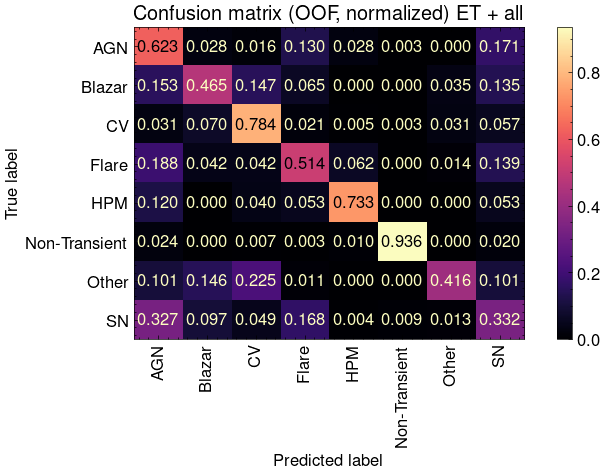

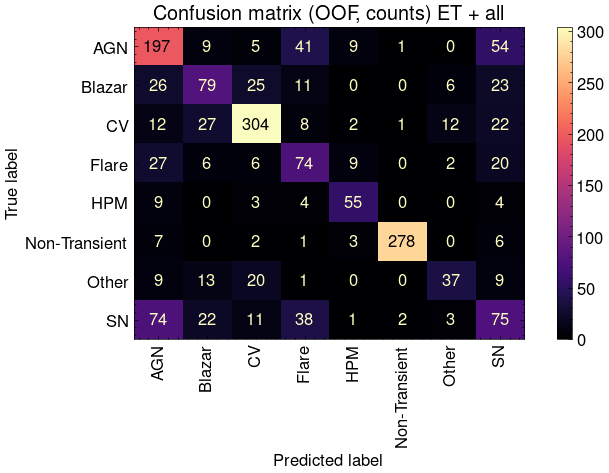

In [5]:
import matplotlib.pyplot as plt
import numpy as np

assert not df_models.empty, "No se encontraron corridas en BASE_DIR."

# Mejor por F1_macro de CV (sin tuning)
best_row = df_models.iloc[0]
print("Mejor corrida por CV F1_macro_mean (sin tuning):")
display(best_row.to_frame().T)

# Cargar OOF del mejor
oof_path = best_row["oof_csv"]
assert oof_path and os.path.exists(oof_path), "No encontré el OOF CSV del mejor modelo."
oof = pd.read_csv(oof_path)

y_true = oof["y_true"].astype(str).values
y_pred = (oof["y_pred"] if "y_pred" in oof.columns else oof["y_pred_tuned"]).astype(str).values
labels = sorted(np.unique(np.concatenate([y_true, y_pred])))

# Métricas globales OOF
print("\n== Métricas OOF (mejor modelo) ==")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1_macro:", f1_score(y_true, y_pred, average="macro"))
print("Precision_macro:", precision_score(y_true, y_pred, average="macro", zero_division=0))
print("Recall_macro:", recall_score(y_true, y_pred, average="macro", zero_division=0))

# Tabla por clase
from sklearn.metrics import precision_recall_fscore_support
prec, rec, f1c, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
per_class_df = pd.DataFrame({
    "class": labels,
    "precision": prec,
    "recall": rec,
    "f1": f1c,
    "support": sup
}).sort_values("f1", ascending=False)
display(per_class_df)

# Matriz de confusión (normalizada por fila)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
fig, ax = plt.subplots(figsize=(8, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(include_values=True, cmap="magma", xticks_rotation=90, values_format=".3f",ax=ax)
plt.title(f"Confusion matrix (OOF, normalized) {best_row['model']} + {best_row['feature_set']}")
ax.set_aspect(0.8)
plt.tight_layout()
plt.savefig("figures/CM_percentaje.pdf",dpi=300,bbox_inches='tight')
plt.show()

# Matriz de confusión cruda (conteos)
cm = confusion_matrix(y_true, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(8, 5))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp2.plot(include_values=True, cmap="magma", xticks_rotation=90, values_format="d",ax=ax)
plt.title(f"Confusion matrix (OOF, counts) {best_row['model']} + {best_row['feature_set']}")
ax.set_aspect(0.8)
plt.tight_layout()
plt.savefig("figures/CM_counts.pdf",dpi=300,bbox_inches='tight')
plt.show()


## Feature importances (en %) para el mejor modelo

,feature,importance_%,Cumm_Importance_%
27,whvg_strength_mean,23.223430,23.223430
28,whvg_strength_std,13.056836,36.280266
29,whvg_disparity_mean,5.441515,41.721781
14,dhvg_transitivity,4.086843,45.808624
23,whvg_transitivity,3.948281,49.756905
16,dhvg_triangles_mean,3.802482,53.559387
25,whvg_triangles_mean,3.692692,57.252079
5,hvg_transitivity,3.564573,60.816653
7,hvg_triangles_mean,3.550169,64.366822
13,dhvg_clustering_mean,3.127019,67.493841


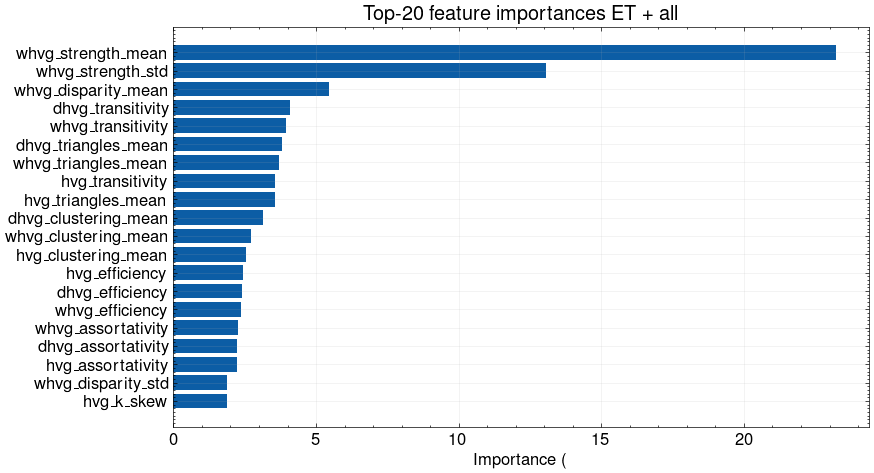

In [6]:
# Intentamos cargar el modelo full y extraer importancias nativas.
# Si además tienes `feats` en este notebook, usaremos nombres de columnas consistentes con feature_set.
from joblib import load as joblib_load

def _drop_constant_features(X: pd.DataFrame) -> pd.DataFrame:
    nunq = X.nunique(dropna=True)
    X = X.drop(columns=nunq[nunq <= 1].index.tolist(), errors='ignore')
    var0 = X.var(axis=0, skipna=True)
    return X.drop(columns=var0[var0 == 0].index.tolist(), errors='ignore')

def _select_feature_set(fullX: pd.DataFrame, feature_set: str) -> pd.DataFrame:
    fs = (feature_set or "all").lower()
    cols = []
    if fs in ("hvg","all"):
        cols += [c for c in fullX.columns if c.startswith("hvg_")]
    if fs in ("dhvg","all"):
        cols += [c for c in fullX.columns if c.startswith("dhvg_")]
    if fs in ("whvg","all"):
        cols += [c for c in fullX.columns if c.startswith("whvg_") or c.startswith("wvg_")]
    seen = set(); cols = [c for c in cols if not (c in seen or seen.add(c))]
    if not cols:
        cols = [c for c in fullX.columns if c.startswith(("hvg_","dhvg_","whvg_","wvg_"))]
    return fullX[cols].copy()

full_model_path = best_row["prefix"] + "_full_model.joblib"
if full_model_path and os.path.exists(full_model_path):
    pipe = joblib_load(full_model_path)
    clf = pipe.named_steps["clf"]
    try:
        importances = clf.feature_importances_
    except Exception:
        importances = None

    # Intentar nombres de features a partir de 'feats' si está en el entorno
    feature_names = None
    if 'feats' in globals():
        X_full = feats.drop(columns=[c for c in ['ID','Classification'] if c in feats.columns]).copy()
        X_full = X_full.apply(pd.to_numeric, errors='coerce')
        X_full = _drop_constant_features(X_full)
        X_sel = _select_feature_set(X_full, best_row["feature_set"])
        feature_names = X_sel.columns.tolist()

    if importances is not None:
        imp = np.array(importances, dtype=float)
        if feature_names is None or len(feature_names) != len(imp):
            feature_names = [f"f{i}" for i in range(len(imp))]

        # Normalizar a %
        total = imp.sum() if imp.sum() > 0 else 1.0
        imp_pct = 100.0 * imp / total
        df_imp = pd.DataFrame({"feature": feature_names, "importance_%": imp_pct})
        df_imp = df_imp.sort_values("importance_%", ascending=False)
        df_imp["Cumm_Importance_%"]=df_imp["importance_%"].cumsum()
        display(df_imp.head(25))

        # Plot top-20
        topk = 20
        top = df_imp.head(topk).iloc[::-1]
        import matplotlib.pyplot as plt
        plt.figure(figsize=(9,5))
        plt.barh(top["feature"], top["importance_%"])
        plt.xlabel("Importance (%)")
        plt.title(f"Top-{topk} feature importances {best_row['model']} + {best_row['feature_set']}")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.savefig("figures/Top_feature_importances.pdf",dpi=300,bbox_inches='tight')
        plt.show()
    else:
        print("El estimador no expone 'feature_importances_' (o no pudo extraerse).")
else:
    print("No encontré el modelo full para extraer importancias.")


## PR-AUC por clase (útil por el desbalance de clases)

,class,PR_AUC
5,Non-Transient,0.986897
2,CV,0.868843
4,HPM,0.766625
0,AGN,0.593435
6,Other,0.498469
1,Blazar,0.487829
3,Flare,0.426517
7,SN,0.348133


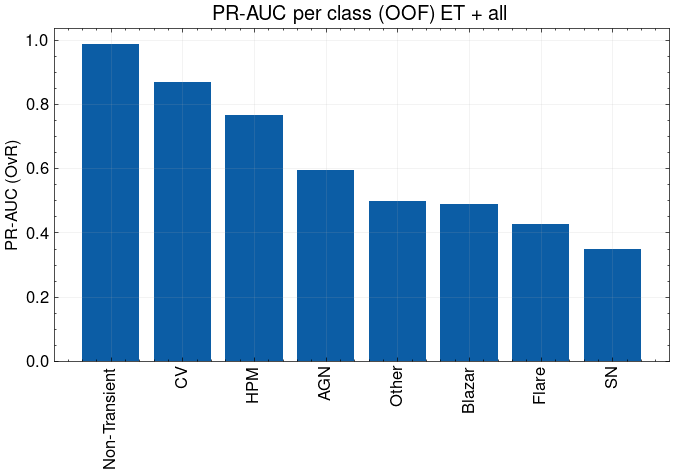

In [7]:
from sklearn.metrics import average_precision_score

proba_cols = [c for c in oof.columns if c.startswith("proba_")]
if proba_cols:
    labels_order = [c.replace("proba_","") for c in proba_cols]
    pr_auc_rows = []
    for i, lab in enumerate(labels_order):
        y_bin = (oof["y_true"].astype(str).values == lab).astype(int)
        pr = average_precision_score(y_bin, oof[proba_cols[i]].values)
        pr_auc_rows.append((lab, pr))
    df_pr = pd.DataFrame(pr_auc_rows, columns=["class","PR_AUC"]).sort_values("PR_AUC", ascending=False)
    display(df_pr)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    plt.bar(df_pr["class"], df_pr["PR_AUC"])
    plt.xticks(rotation=90)
    plt.ylabel("PR-AUC (OvR)")
    plt.title(f"PR-AUC per class (OOF) {best_row['model']} + {best_row['feature_set']}")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig("figures/PR-AUC.pdf",dpi=300,bbox_inches='tight')    
    plt.show()
else:
    print("No hay columnas de probabilidad en el OOF; salto PR-AUC.")


## Some plots of magg for some clases...

In [8]:
feats

,ID,Classification,hvg_k_mean,hvg_k_std,hvg_k_skew,hvg_lambda_tail,hvg_clustering_mean,hvg_transitivity,hvg_assortativity,hvg_triangles_mean,...,whvg_transitivity,whvg_assortativity,whvg_triangles_mean,whvg_efficiency,whvg_strength_mean,whvg_strength_std,whvg_disparity_mean,whvg_disparity_std,whvg_eig_fiedler,whvg_eig_max
0,1611101400424116462,Flare,3.924051,2.253111,1.559444,0.399972,0.645258,0.349904,0.144794,2.895570,...,0.349904,0.144794,2.895570,0.194089,2.718727,3.466671,0.443113,0.188202,5.743225e-03,1.887671
1,1611091630244128695,HPM,3.775862,2.093035,1.650768,0.405004,0.617796,0.358469,-0.010381,2.663793,...,0.358469,-0.010381,2.663793,0.240948,0.764053,0.962995,0.477555,0.207525,7.442491e-03,1.923236
2,1611071120084120846,HPM,3.908197,2.132827,1.428508,0.437095,0.630461,0.359703,0.092565,2.862295,...,0.359703,0.092565,2.862295,0.184198,1.507742,1.461046,0.470659,0.197582,1.775210e-03,1.937125
3,1611021070314137583,Other,3.832335,2.351335,2.233471,0.335960,0.628044,0.337719,0.039592,2.766467,...,0.337719,0.039592,2.766467,0.225883,5.948086,9.689918,0.511115,0.212871,2.144283e-03,1.924935
4,1610291630224109495,HPM,3.886525,2.137448,1.369459,0.364153,0.632213,0.358491,0.081368,2.829787,...,0.358491,0.081368,2.829787,0.229897,0.816165,0.867874,0.452730,0.192846,3.980516e-03,1.850539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,1129042024282,Non-Tr.,3.152000,1.499632,1.677078,0.627908,0.378499,0.245793,0.138359,1.110000,...,0.245793,0.138359,1.110000,0.136694,2.461824,11.781800,0.559917,0.286378,-9.170618e-16,2.000000
1702,1115045042760,Non-Tr.,3.588000,1.980469,1.864767,0.453119,0.525487,0.290733,0.117192,1.920000,...,0.290733,0.117192,1.920000,0.160138,1.309777,1.532185,0.496238,0.223421,8.820763e-16,2.000000
1703,1132039036866,Non-Tr.,3.728000,2.080869,1.542157,0.443043,0.577243,0.322759,0.114652,2.340000,...,0.322759,0.114652,2.340000,0.148693,1.914392,1.605744,0.472100,0.213540,2.363324e-16,1.912716
1704,1126045048959,Non-Tr.,3.234469,1.571009,1.981498,0.578244,0.413296,0.260438,0.105737,1.262525,...,0.260438,0.105737,1.262525,0.127553,0.737759,0.741151,0.544586,0.266951,-1.459267e-15,2.000000
